<a href="https://colab.research.google.com/github/Raunit123/House_Price_Prediction/blob/main/Music_Generation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml

COMET_API_KEY = "f7JspBcAC917YKIMGU9u3yaIG"
import tensorflow as tf

!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl


import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.0/418.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:

In [5]:
songs = mdl.lab1.load_training_data()

first_song =songs[0]
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [6]:
songs_joined = "\n\n".join(songs)
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [8]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [9]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [10]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output



vectorized_songs = vectorize_string(songs_joined)

In [11]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [12]:
def get_batch(vectorized_songs, seq_length, batch_size):

  n = vectorized_songs.shape[0] - 1

  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch



test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [13]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 82 (np.str_('|'))
  expected output: 59 (np.str_('d'))
Step   1
  input: 59 (np.str_('d'))
  expected output: 14 (np.str_('2'))
Step   2
  input: 14 (np.str_('2'))
  expected output: 27 (np.str_('B'))
Step   3
  input: 27 (np.str_('B'))
  expected output: 59 (np.str_('d'))
Step   4
  input: 59 (np.str_('d'))
  expected output: 1 (np.str_(' '))


In [14]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim),


    LSTM(rnn_units),

    tf.keras.layers.Dense(vocab_size)
  ])

  return model


model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.build(tf.TensorShape([32, 100]))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 256)              │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 100, 1024)             │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 100, 83)               │          85,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [18]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([28, 49, 47, 41, 35, 66, 16,  0, 52, 15, 32, 44,  8, 41, 37, 38,  5,
       60, 71, 55, 58, 65, 59, 12, 38, 35, 22, 37, 64, 20, 68, 22,  1, 63,
       69, 50, 19, 61, 20,  2, 59, 10,  4, 65, 59, 41, 59, 35, 50, 73, 42,
       80, 65, 70, 69, 24, 25,  8, 76, 26, 19, 22, 63, 69,  6, 51, 73,  6,
        1, 62, 53, 72, 66, 18, 66, 54, 23, 26, 65, 37,  9, 63, 60, 46, 78,
       43, 45, 66, 48, 20, 22, 71, 20, 78, 54, 82, 69,  6, 43, 11])

In [19]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'e efg|afd bge|afd gec|dBG Bcd:|!\ncBA Aaf|ecA Bcd|cBA gfe|dBG Bcd|!\ncBA Aaa|Agg|Aff|Aee efg|dBG Bcd:|'

Next Char Predictions: 
 "CXVPJk4\n[3GS,PLM'ep_cjd0MJ:Li8m: hnY7f8!d.#jdPdJYrQyjon=>,uA7:hn(Zr( g]qk6k^<AjL-heUwRTkW8:p8w^|n(R/"


In [20]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

example_batch_loss = compute_loss(y, pred)


print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4174633


In [21]:


vocab_size = len(vocab)


params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt.weights.h5")
os.makedirs(checkpoint_dir, exist_ok=True)

In [22]:
def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

 21%|██        | 637/3000 [32:38<2:01:05,  3.07s/it]


KeyboardInterrupt: 

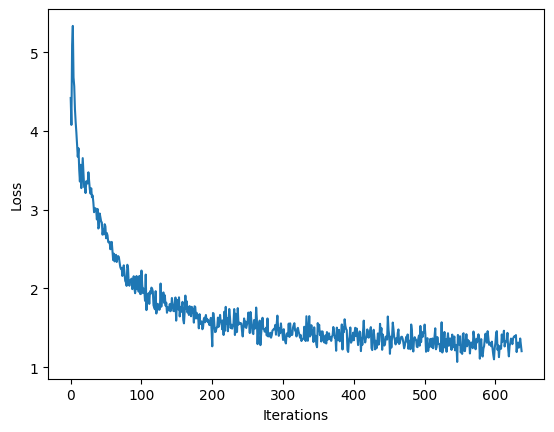

In [23]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], params["batch_size"])
# model = build_model('''TODO: arguments''')

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])
# optimizer = # TODO

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Now, compute the gradients
  '''TODO: complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all
      of the model parameters.
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # log the loss to the Comet interface! we will be able to track it there.
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  # Update the progress bar and also visualize within notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
experiment.flush()


In [24]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.build(tf.TensorShape([1, None]))
model.load_weights(checkpoint_prefix)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, None, 256)              │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, None, 1024)             │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, None, 83)               │          85,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO
      # text_generated.append('''TODO''')

  return (start_string + ''.join(text_generated))

In [27]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

NameError: name 'generated_text' is not defined

In [28]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : changing_watermelon_8513
COMET INFO:     url                   : https://www.comet.com/raunit123/6s191-lab1-part2/76a9698ebc6e46798fc0979ad01474dc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [638] : (1.0675004720687866, 5.333642482757568)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1XYeE8Ym_MbojuEZeMMA_U-2-8UrlfUfu
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     learning_rate           : 0.005
COMET INFO:     num_training_iterations : 3000
COMET INFO:     rnn_units               : 1024
COMET